<h4><b>Importing necessary libraries and connecting to the database</b></h4>

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

conn = sqlite3.connect("../ecommerce.db")


<h4><b>Importing the RFM table from the database</b></h4>

In [2]:
rfm = pd.read_sql("SELECT * FROM rfm_customers",conn)
rfm.describe()


,customer_id,monetary,monetary_log,recency_days,frequency,cluster
count,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,2054.266460,6.593627,92.059474,91.720609,1.051406
std,1721.808492,8989.230441,1.257578,100.012264,228.785094,0.720198
min,12346.000000,3.750000,1.558145,0.000000,1.000000,0.000000
25%,13813.250000,307.415000,5.731446,17.000000,17.000000,1.000000
50%,15299.500000,674.485000,6.515431,50.000000,41.000000,1.000000
75%,16778.750000,1661.740000,7.416222,141.750000,100.000000,2.000000
max,18287.000000,280206.020000,12.543284,373.000000,7847.000000,3.000000


<h4><b>Selecting Features for Clustering</b></h4>

In [3]:
X = rfm[["recency_days", "frequency", "monetary_log"]]

<h4><b>Scaling Features</b></h4>

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

<h4><b>Using Elbow Method and Silhouette Method to find the optimal value of K</b><h4>

In [5]:
inertia = []
silhouette = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, labels))


<h5>Plotting graphs <h5>

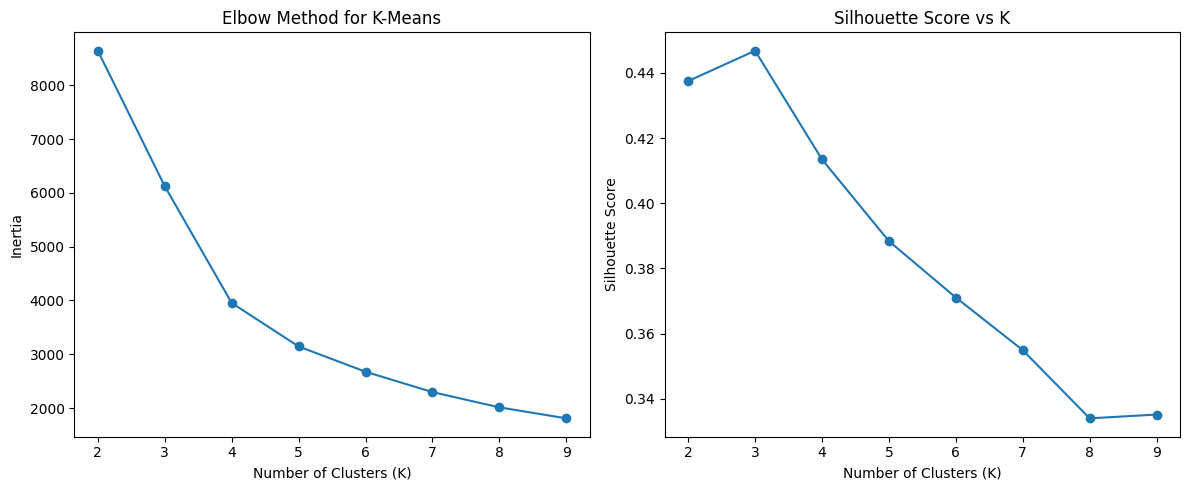

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Elbow plot (Inertia)
axes[0].plot(K_range, inertia, marker='o')
axes[0].set_xlabel("Number of Clusters (K)")
axes[0].set_ylabel("Inertia")
axes[0].set_title("Elbow Method for K-Means")

# Silhouette plot
axes[1].plot(K_range, silhouette, marker='o')
axes[1].set_xlabel("Number of Clusters (K)")
axes[1].set_ylabel("Silhouette Score")
axes[1].set_title("Silhouette Score vs K")

plt.tight_layout()
plt.show()

<p>From the above plots, the Elbow method indicates a point of diminishing returns around K = 4–6, where the reduction in inertia begins to level off. 
<br>The silhouette score reaches its maximum at K = 3, but remains relatively stable across K = 3-5 ( scores are in range of 0.3-0.4, which is expected for customer behavioural data) </p>

<h4>Thus, we will be using <b>K = 4</b> as this value of K shows a clear elbow, a stable silhouette score and aligns with our previous segmentation <h4>

<h4><b>Fitting K-Means with k=4</b><h4>

In [7]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm["cluster"] = kmeans.fit_predict(X_scaled)

rfm["cluster"].value_counts()


1    2089
2    1230
0    1015
3       4
Name: cluster, dtype: int64

<h4><b>Understanding Cluster Behaviour using cluster centroids</b></h4>

In [8]:
cluster_profile = (
    rfm
    .groupby("cluster")
    .agg(
        no_of_customers=("customer_id", "count"),
        total_revenue=("monetary", "sum"),   # 👈 ADD THIS
        monetary=("monetary", "mean"),
        monetary_log=("monetary_log", "mean"),
        frequency=("frequency", "mean"),
        recency_days=("recency_days", "mean"),
        recency_median=("recency_days", "median"),
        monetary_median=("monetary", "median"),
        monetarylog_median=("monetary_log", "median"),
        frequency_median=("frequency", "median"),
    )
    .sort_values("total_revenue", ascending=False)
)

cluster_profile["revenue_share_%"] = (
    cluster_profile["total_revenue"]
    / cluster_profile["total_revenue"].sum()
) * 100


cluster_profile

,no_of_customers,total_revenue,monetary,monetary_log,frequency,recency_days,recency_median,monetary_median,monetarylog_median,frequency_median,revenue_share_%
cluster,,,,,,,,,,,
2,1230,6954161.751,5653.790041,8.095598,211.087805,29.700813,17.0,2738.445,7.915510,146.0,78.036623
1,2089,1254851.773,600.694961,6.159326,42.807085,51.272858,43.0,537.060,6.287970,33.0,14.081409
0,1015,418693.230,412.505645,5.649979,25.215764,251.928079,247.0,298.890,5.703416,17.0,4.698396
3,4,283701.150,70925.287500,11.002016,5807.000000,1.500000,1.0,53078.180,10.852918,5393.0,3.183573


<h4><b>Interpretation of the clusters based on the centroid analysis above:</b></h4>
<ul>
<li>Cluster 3 → Ultra High-Value Outliers(4 customers making up more than 3% of the revenue)</li>
<li>Cluster 2 → Active High-Value Customers</li>
<li>Cluster 1 → Active Low-Value customers</li>
<li>Cluster 0 → Inactive Low-Value customers</li>
</ul>

<h4><b>Checking Where the customers from RFM Segmentation land in K-Means Space</b></h4>

In [9]:
pd.crosstab(rfm['segments'], rfm['cluster'])


cluster,0,1,2,3
segments,,,,
Active High-Value,0,238,1074,4
Active Low-Value,0,767,1,0
Inactive High-Value,81,183,155,0
Inactive Low-Value,934,901,0,0


### K-Means Clustering Summary

K-Means clustering was conducted as a complementary, data-driven approach to examine natural groupings in customer purchasing behavior. The resulting clusters show strong alignment with RFM segmentation for active customers, with clusters largely corresponding to RFM-based Active High-Value and Active Low-Value segments.

K-Means additionally surfaced heterogeneity within active high-value customers by isolating a very small cluster of extreme high-value customers (Cluster 3), reflecting pronounced revenue concentration compared to its size.

However, Inactive High-Value customers were not captured as a distinct cluster and were distributed across multiple clusters, indicating that these type of customers are more effectively identified using rule-based segmentation than distance-based clustering alone.

<h4><b>Exporting Data to Database</b></h4>

In [10]:
rfm.to_sql("rfm_customers",conn,if_exists="replace",index=False)
print(pd.read_sql("SELECT COUNT(*) FROM rfm_customers",conn))
pd.read_sql("SELECT * FROM rfm_customers LIMIT 5", conn)

   COUNT(*)
0      4338


,customer_id,monetary,monetary_log,last_purchase_date,recency_days,frequency,r_score,f_score,m_score,rfm_code,segments,cluster
0,12346,77183.60,11.253955,2011-01-18 00:00:00,325,1,1,1,5,115,Inactive High-Value,2
1,12347,4310.00,8.368925,2011-12-07 00:00:00,2,182,5,5,5,555,Active High-Value,2
2,12348,1797.24,7.494564,2011-09-25 00:00:00,75,31,2,3,4,234,Inactive High-Value,2
3,12349,1757.55,7.472245,2011-11-21 00:00:00,18,73,4,4,4,444,Active High-Value,2
4,12350,334.40,5.815324,2011-02-02 00:00:00,310,17,1,2,2,122,Inactive Low-Value,0
